Let's take a look at some data that came from my solar panels and try to apply the techniques in the exploration section.

In [1]:
#data manipulation
import numpy as np
import pandas as pd

from datetime import datetime
import itertools

#data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm


from sklearn.model_selection import TimeSeriesSplit

#ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
df_solar=pd.read_csv("solar.csv")
df_solar=df_solar.rename(columns={'Date/Time':'date','Energy Produced (Wh)':'watt_hours'})

In [3]:
df_solar.head()

,date,watt_hours
0,2018-10-11 00:00:00 -0500,1985
1,2018-10-12 00:00:00 -0500,0
2,2018-10-13 00:00:00 -0500,0
3,2018-10-14 00:00:00 -0500,0
4,2018-10-15 00:00:00 -0500,0


In [4]:
#Remove last row that has the total watt-hours generated for the time period
df_solar[df_solar['date']=='Total']
df_solar.drop(df_solar[df_solar['date']=='Total'].index,inplace=True)

In [5]:
#drop the time portion of the date since it doesn't vary
df_solar['date']=df_solar.date.apply(lambda x: x.split(" ")[0])

In [6]:
#drop the beginning observations where they initially turned on my monitoring on my panels
#but they were not generating power
df_solar=df_solar[df_solar['watt_hours']!=0]
df_solar=df_solar.iloc[1:,:].reset_index().drop(columns=['index'])
df_solar.head()

,date,watt_hours
0,2018-11-07,10777
1,2018-11-08,7677
2,2018-11-09,7889
3,2018-11-10,12209
4,2018-11-11,5609


In [7]:
#convert cleaned up column to a pandas datetime format
df_solar['date']=pd.to_datetime(df_solar['date'],format='%Y-%m-%d')

In [8]:
df_solar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 2 columns):
date          360 non-null datetime64[ns]
watt_hours    360 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 5.7 KB


In [9]:
X=df_solar.date
y=df_solar.watt_hours

In [10]:
tss=TimeSeriesSplit(n_splits=5,max_train_size=None)
for train_index,test_index in tss.split(X):
    print("TRAIN:",train_index,"TEST:",test_index)
    X_train,X_test=X[train_index],X[test_index]
    y_train,y_test=y[train_index],y[test_index]

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59] TEST: [ 60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 119]
TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119] TEST: [120 121 122 123 124 125 126 127 128 129 130 131 132 133 

If we look at the splits we can see that train and test are consecutive i.e. observations in test data pick up right after the observations in train data. They are **ordered**(no random states here!)

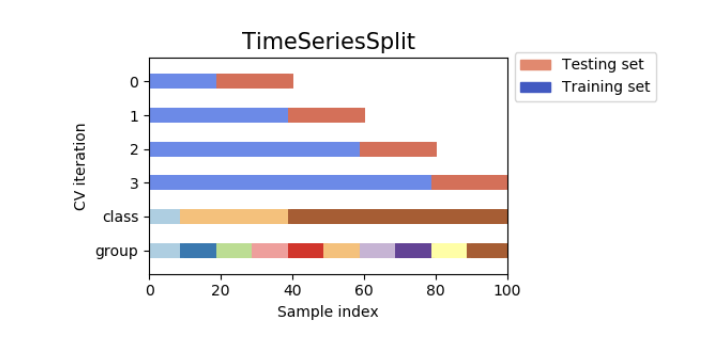

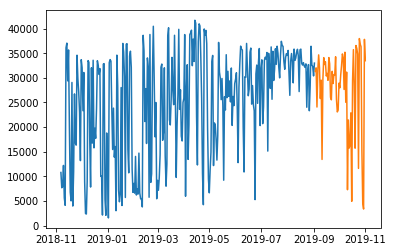

In [11]:
plt.plot(X_train,y_train)
plt.plot(X_test,y_test)

In [12]:
print(X_train.tail())
print(X_test.head())
print(X_test.tail())

295   2019-08-29
296   2019-08-30
297   2019-08-31
298   2019-09-01
299   2019-09-02
Name: date, dtype: datetime64[ns]
300   2019-09-03
301   2019-09-04
302   2019-09-05
303   2019-09-06
304   2019-09-07
Name: date, dtype: datetime64[ns]
355   2019-10-28
356   2019-10-29
357   2019-10-30
358   2019-10-31
359   2019-11-01
Name: date, dtype: datetime64[ns]


In [13]:
#We will set the index to be the date to show some resampling methods that require
#the date be the index as well as using .loc to split the data manually
df_solar=df_solar.set_index('date')
df_solar.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 360 entries, 2018-11-07 to 2019-11-01
Data columns (total 1 columns):
watt_hours    360 non-null int64
dtypes: int64(1)
memory usage: 5.6 KB


In [14]:
aggregation='mean'
train=df_solar.loc['2018-11-07':'2019-08-08'].watt_hours.resample('W').agg(aggregation)
test=df_solar.loc['2019-08-09':].watt_hours.resample('W').agg(aggregation)
print('Observations: %d' % (len(train.values)+len(test.values)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 53
Training Observations: 40
Testing Observations: 13


In [15]:
print(train.head(10))
print(test.head(10))

date
2018-11-11     8832.200000
2018-11-18    24180.142857
2018-11-25    15546.714286
2018-12-02    27639.142857
2018-12-09    15796.142857
2018-12-16    22361.571429
2018-12-23    27121.000000
2018-12-30    13602.000000
2019-01-06    22562.714286
2019-01-13    19316.714286
Freq: W-SUN, Name: watt_hours, dtype: float64
date
2019-08-11    34473.000000
2019-08-18    33886.428571
2019-08-25    31205.571429
2019-09-01    30886.428571
2019-09-08    31241.000000
2019-09-15    28370.142857
2019-09-22    29914.000000
2019-09-29    29210.000000
2019-10-06    30347.285714
2019-10-13    23366.000000
Freq: W-SUN, Name: watt_hours, dtype: float64


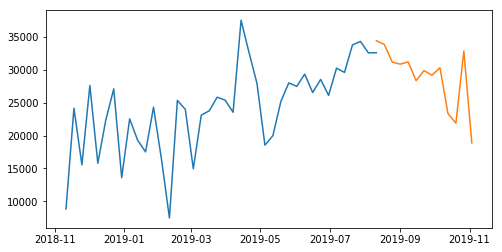

In [16]:
plt.figure(figsize=(8,4))
plt.plot(train)
plt.plot(test)
plt.show()

In [17]:
#I tried to do around a 70/30 split above but it can be done more formally
#by using len function and the percentage you want in train and test
df_solar1=df_solar.reset_index()
train_size=int(len(df_solar1)*.70)
train1,test1=df_solar1[0:train_size],df_solar1[train_size:len(df_solar1)]
print('Observations: %d'% (len(df_solar1)))
print('Observations: %d'% (len(train1)))
print('Observations: %d'% (len(test1)))

Observations: 360
Observations: 251
Observations: 109


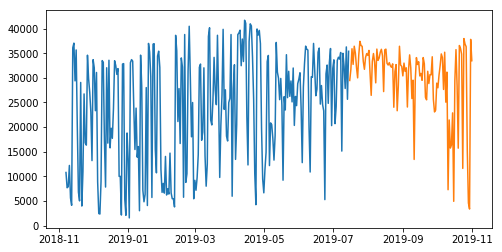

In [23]:
plt.figure(figsize=(8,4))
plt.plot(train1.set_index('date'))
plt.plot(test1.set_index('date'))
#Why are the plotting on seperate graphs the second way?

## Visualizing time series data
Now that we have shown different techniques for train/test split with time series data lets look at a few ways to visualize it along with some different aggregation techniques

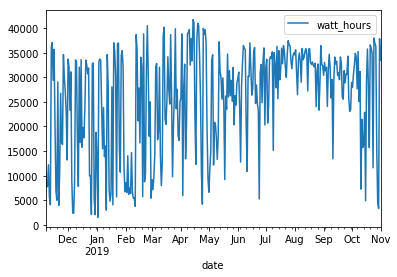

In [25]:
#daily
df_solar.plot()
plt.show()

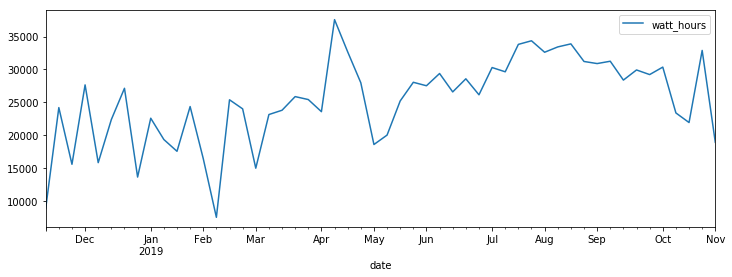

In [26]:
#weekly using mean  
df_solar.resample('W').mean().plot(figsize=(12,4))
plt.show()

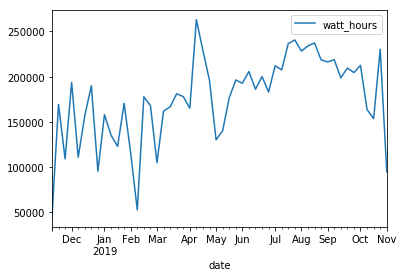

In [28]:
#weekly using the sum aggregation
df_solar.resample('W').sum().plot()
plt.show()

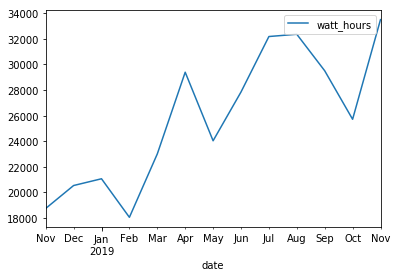

In [30]:
df_solar.resample('MS').mean().plot()
plt.show()

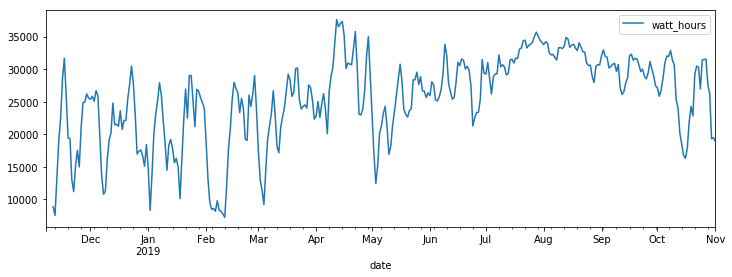

In [31]:
#5 day rolling average
df_solar.rolling(5).mean().plot(figsize=(12,4))
plt.show()

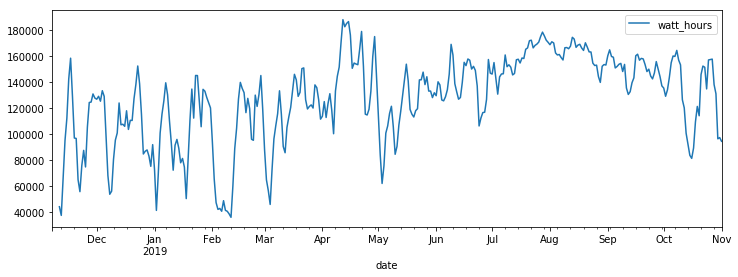

In [33]:
#moving 5 day sum
df_solar.rolling(5).sum().plot(figsize=(12,4))
plt.show()

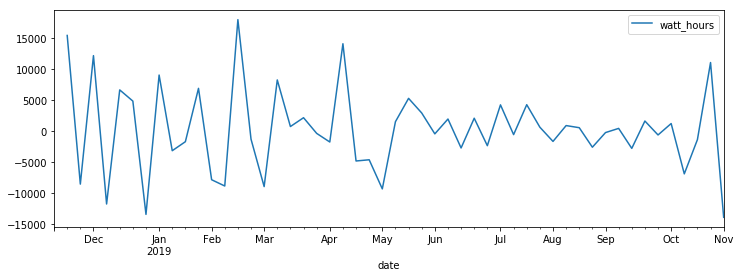

In [35]:
#1 week differences
df_solar.resample('W').mean().diff(periods=1).plot(figsize=(12,4))
plt.show()

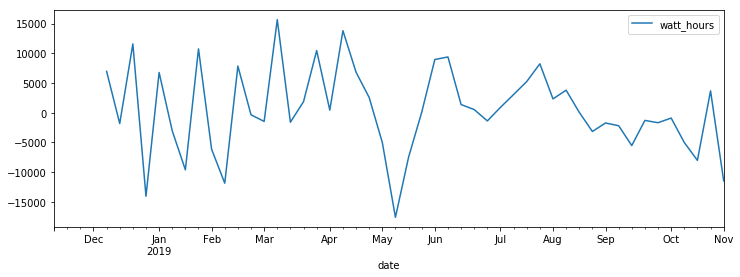

In [37]:
#4 week differences
df_solar.resample('W').mean().diff(periods=4).plot(figsize=(12,4))
plt.show()

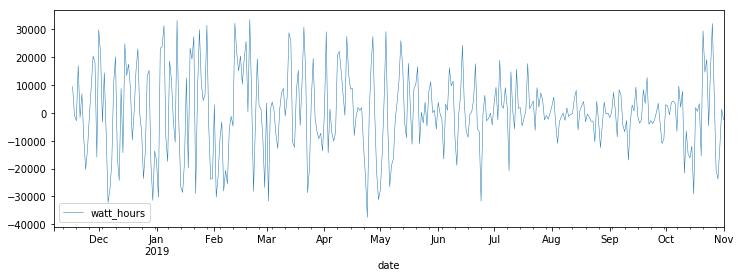

In [39]:
#10 day difference
df_solar.diff(periods=10).plot(figsize=(12,4),linewidth=0.5)
plt.show()

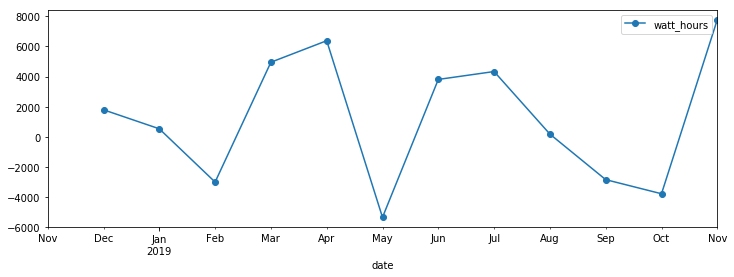

In [40]:
#month over month 
df_solar.resample('MS').mean().diff(periods=1).plot(figsize=(12,4),marker='o',linestyle='-')

year over year doesn't make sense since we only have a year of data

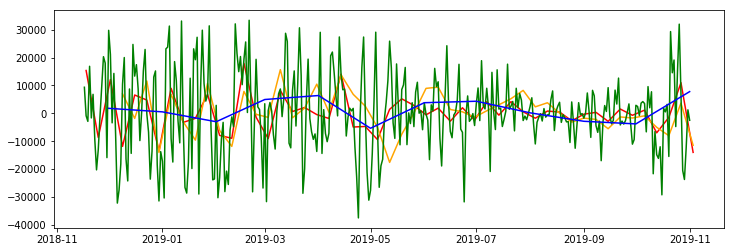

In [44]:
plt.figure(figsize=(12,4))
plt.plot(df_solar.resample('W').mean().diff(periods=1),color='red')
plt.plot(df_solar.resample('W').mean().diff(periods=4),color='orange')
plt.plot(df_solar.diff(periods=10),color='green')
plt.plot(df_solar.resample('MS').mean().diff(periods=1),color='blue')

The ticks on the axis for datetimes can also be customized
with the matplotlib.dates module

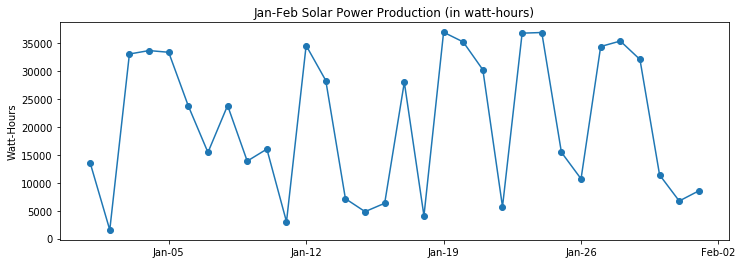

In [49]:
import matplotlib.dates as mdates

fig,ax=plt.subplots(figsize=(12,4))
ax.plot(df_solar.loc['2019-01-01':'2019-02-01'],marker='o',linestyle='-')
ax.set_ylabel('Watt-Hours')
ax.set_title('Jan-Feb Solar Power Production (in watt-hours)')
#set the x-axis to weekly interval on Saturdays
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.SATURDAY))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))

## Seasonality

In [56]:
df_solar['weekday_name']=df_solar.index.weekday_name
df_solar.head()

,watt_hours,weekday_name
date,,
2018-11-07,10777,Wednesday
2018-11-08,7677,Thursday
2018-11-09,7889,Friday
2018-11-10,12209,Saturday
2018-11-11,5609,Sunday


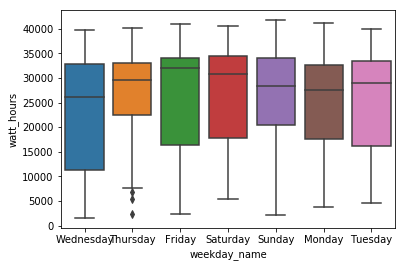

In [57]:
#now lets group the time series by the day of the week and explore the spread
sns.boxplot(data=df_solar,x='weekday_name',y='watt_hours')

## Two time frequencies in same chart

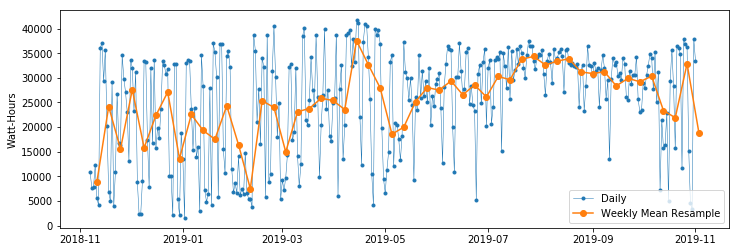

In [59]:
#plot daily and weekly resampled time series together
fig,ax=plt.subplots(figsize=(12,4))
ax.plot(df_solar[['watt_hours']],marker='.',linestyle='-',linewidth=0.5,label='Daily')
ax.plot(df_solar[['watt_hours']].resample('W').mean(),marker='o',linestyle='-',label='Weekly Mean Resample')
ax.set_ylabel('Watt-Hours')
ax.legend();

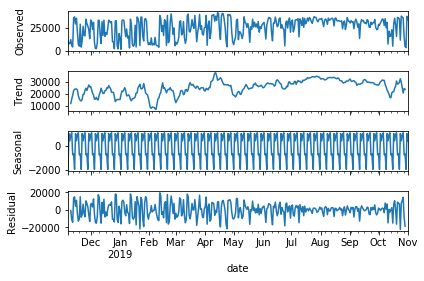

In [69]:
## Time-Series-Decomposition
##Note that results are not meaningful since we only have a year of data
df_solar=df_solar.drop(columns='weekday_name')
decomposition=sm.tsa.seasonal_decompose(df_solar,model='additive')
fig=decomposition.plot()
plt.show()

## Plotting lag

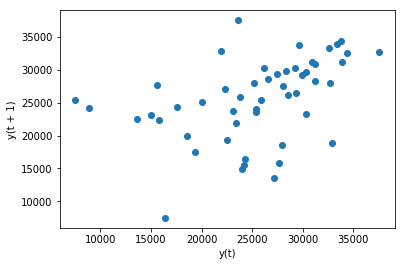

In [70]:
# We are basically looking for correlation between current and next weekly vlaue of target variable
pd.plotting.lag_plot(df_solar.resample('W').mean(),lag=1)

In [75]:
df_corr=pd.concat([df_solar.shift(-1),df_solar],axis=1)
df_corr.columns=['t-1','t']
df_corr.corr()

,t-1,t
t-1,1.000000,0.407301
t,0.407301,1.000000
